In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


In [102]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dataset_path = path + '/PetImages'
IMG_SIZE = (30, 30)
IMG_NUM = 1000

def load_images(dataset_path, size, grayscale):
    images = []
    labels = []
    for label, class_name in enumerate(['Cat', 'Dog']):
        class_dir = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_dir)[:IMG_NUM]:
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
            if img is None:
                continue
            img = cv2.resize(img, size)
            images.append(img.flatten())
            labels.append(label)
    return np.array(images), np.array(labels)

In [103]:
images, labels = load_images(dataset_path, IMG_SIZE, True)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, stratify=labels, random_state=87)

In [104]:
# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Обучение без PCA
clf_no_pca = LogisticRegression(
    penalty='l2',
    C=0.5,
    max_iter=1000
)
clf_no_pca.fit(X_train, y_train)

# Оценка качества без PCA
y_pred_no_pca = clf_no_pca.predict(X_test)
accuracy_no_pca = accuracy_score(y_test, y_pred_no_pca)
print(f'Accuracy without PCA test: {accuracy_no_pca:.4f}')

y_pred_no_pca_train = clf_no_pca.predict(X_train)
accuracy_no_pca_train = accuracy_score(y_train, y_pred_no_pca_train)
print(f'Accuracy without PCA train: {accuracy_no_pca_train:.4f}')

Accuracy without PCA test: 0.5400
Accuracy without PCA train: 0.9142


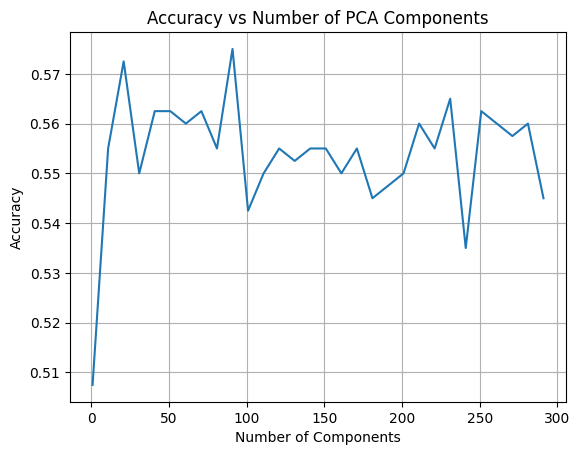

In [105]:
accuracy_list = []
explained_variance_list = []

components_range = range(1, 301, 10)

for n_components in components_range:
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    clf_pca = LogisticRegression(
      penalty='l2',
      C=0.5,
      max_iter=1000
    )
    clf_pca.fit(X_train_pca, y_train)

    y_pred_pca = clf_pca.predict(X_test_pca)
    accuracy_list.append(accuracy_score(y_test, y_pred_pca))
    explained_variance_list.append(np.sum(pca.explained_variance_ratio_))

# График зависимости точности от числа компонент
plt.plot(components_range, accuracy_list, label='Accuracy')
plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of PCA Components')
plt.grid(True)
plt.show()


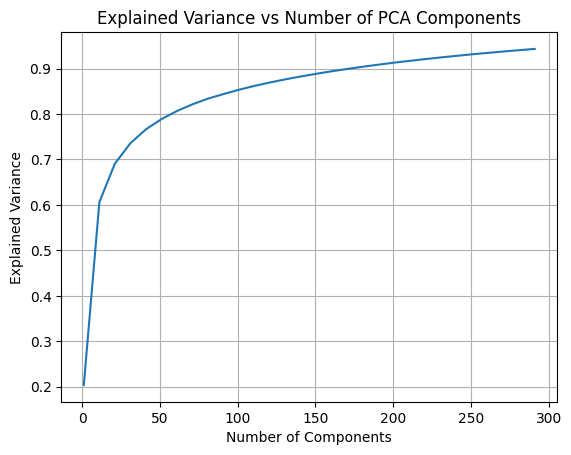

In [107]:
# График зависимости объясненной дисперсии от числа компонент
plt.plot(components_range, explained_variance_list, label='Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs Number of PCA Components')
plt.grid(True)
plt.show()

In [113]:
# Определение числа компонент для объяснения 90% дисперсии
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train)

# Сумма объясненной дисперсии
explained_variance_cumsum = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(explained_variance_cumsum >= 0.90) + 1
print(f'Number of components to explain 90% variance: {n_components_90}')

Number of components to explain 90% variance: 171


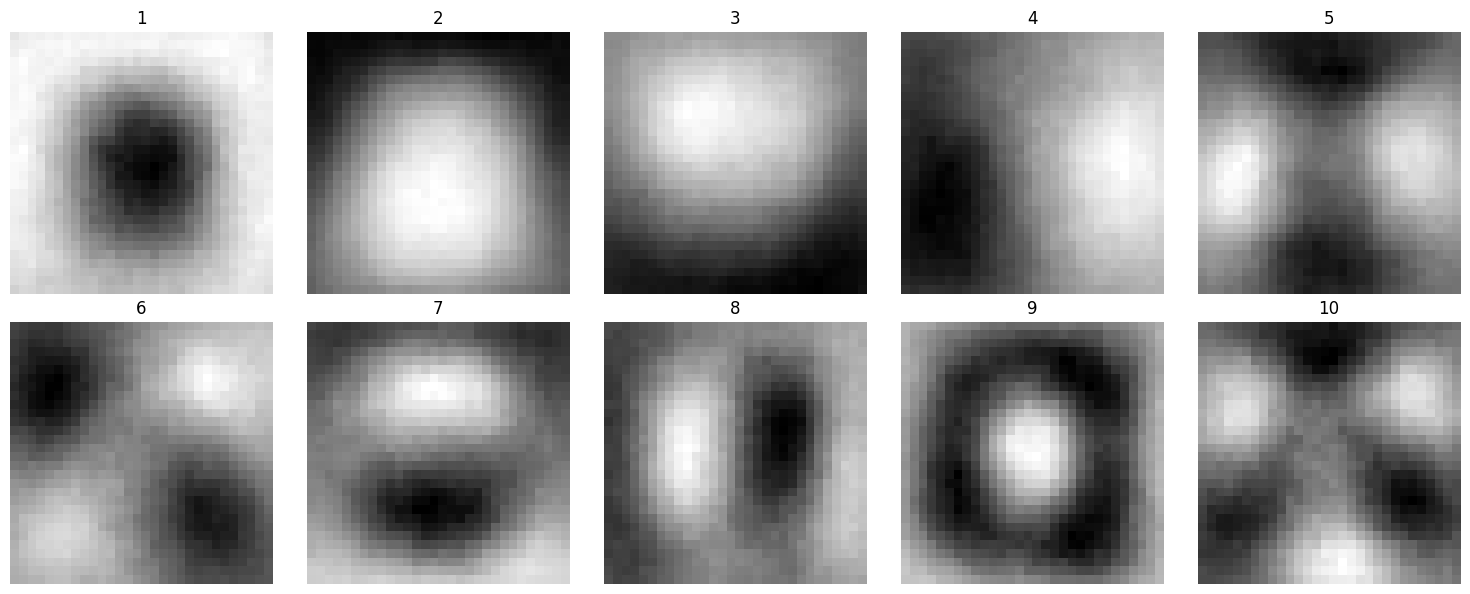

In [114]:
# Первые 10 главных компонент
components = pca.components_

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    component_img = components[i].reshape(IMG_SIZE)
    axes[i].imshow(component_img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f'{i+1}')

plt.tight_layout()
plt.show()